In [35]:
# Execute cell one time

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
# ldaCoherence Script
# Calculate total number of topics in corpus
import nltk
import re
import pickle
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
import spacy
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# NLTK Stop words - manually installed
# verified installation successful
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [37]:
# Download the 'en' and 'en_core_web_sm' model via spacy
!{sys.executable} -m spacy download en

You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/en_core_web_sm
-->
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [42]:
# load May data file (may_w01.csv) grepped from tweetText.csv
df = pd.read_csv('/Volumes/twitter_project/data/Covid19_ASTATE_raw/tweetText_mask_may.csv')

print(df.tail())

                         id                      created_at  \
386138  1267244265773559808  Sun May 31 23:59:11 +0000 2020   
386139  1267244300015931393  Sun May 31 23:59:20 +0000 2020   
386140  1267244344932814852  Sun May 31 23:59:30 +0000 2020   
386141  1267244349823352832  Sun May 31 23:59:31 +0000 2020   
386142  1267244416290480131  Sun May 31 23:59:47 +0000 2020   

                                                full_text hashtags  
386138  "@barrydesr @brithume Stay-at-home, test/trace...      NaN  
386139  "@maskedredline @MayorBowser Her indecision an...      NaN  
386140  "@HollisGOP The CV is in the past who needs ma...      NaN  
386141  "@WSJ F U Wall Street Journal &amp; any other ...     MAGA  
386142  "@nypost Early March they said that Covid-19 w...      NaN  


In [43]:
# Convert to list
data = df.full_text.values.tolist()

# Remove distracting double quotes
data = [re.sub("\"", "", sent) for sent in data]
# probably need to remove 'amp' as well (in dataset as an ampersand)
data = [re.sub("https|amp", "", sent) for sent in data]
pprint(data[:1])

['Wear masks and bring along hand sanitizer. Do not trust anyone around you. '
 'Protect yourself. Biarlah orang nak cakap kau paranoid ke apa']


In [44]:
data_words = list(sent_to_words(data))
print(data_words[:1])

[['wear', 'masks', 'and', 'bring', 'along', 'hand', 'sanitizer', 'do', 'not', 'trust', 'anyone', 'around', 'you', 'protect', 'yourself', 'biarlah', 'orang', 'nak', 'cakap', 'kau', 'paranoid', 'ke', 'apa']]


In [45]:
# Build the bigram/trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) #higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['wear', 'masks', 'and', 'bring', 'along', 'hand_sanitizer', 'do', 'not', 'trust', 'anyone', 'around', 'you', 'protect', 'yourself', 'biarlah', 'orang', 'nak', 'cakap', 'kau', 'paranoid', 'ke', 'apa']


In [46]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [47]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [48]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['wear', 'mask', 'bring', 'trust', 'protect', 'cakap', 'paranoid', 'apa']]


In [49]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.214*"social" + 0.212*"still" + 0.148*"distancing" + 0.118*"even" + '
  '0.054*"back" + 0.049*"bring" + 0.034*"away" + 0.033*"last" + 0.028*"year" + '
  '0.020*"normal"'),
 (1,
  '0.155*"day" + 0.131*"time" + 0.118*"would" + 0.112*"come" + 0.078*"forget" '
  '+ 0.055*"die" + 0.041*"real" + 0.035*"reason" + 0.035*"walk" + '
  '0.027*"little"'),
 (2,
  '0.355*"mask" + 0.177*"wear" + 0.072*"pandemic" + 0.059*"go" + '
  '0.048*"protest" + 0.026*"case" + 0.025*"stay" + 0.023*"take" + 0.020*"keep" '
  '+ 0.019*"distance"'),
 (3,
  '0.419*"get" + 0.156*"good" + 0.139*"give" + 0.083*"bad" + 0.076*"never" + '
  '0.026*"system" + 0.012*"name" + 0.005*"mistake" + 0.002*"program" + '
  '0.000*"safe"'),
 (4,
  '0.326*"virus" + 0.089*"need" + 0.055*"help" + 0.044*"really" + 0.044*"tell" '
  '+ 0.036*"country" + 0.029*"corona" + 0.021*"enough" + 0.021*"act" + '
  '0.021*"end"'),
 (5,
  '0.263*"sick" + 0.224*"spread" + 0.128*"other" + 0.066*"sanitizer" + '
  '0.052*"prevent" + 0.048*"find" + 

In [51]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.220093853285938

Coherence Score:  0.26511308444535764


In [53]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# and update the following path to reflect location on your system
mallet_path = '/Volumes/twitter_project/scripts/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('end', 0.04378052121017484),
   ('read', 0.035005525696851766),
   ('real', 0.030717207114452767),
   ('person', 0.027656821165780353),
   ('point', 0.025748802765682116),
   ('post', 0.022612851731857297),
   ('government', 0.018485108955407153),
   ('happen', 0.01768222992566285),
   ('question', 0.017389415220697278),
   ('people', 0.016501525470156514)]),
 (0,
  [('trump', 0.07439876576821854),
   ('realdonaldtrump', 0.03533895997821944),
   ('lie', 0.03179054360649787),
   ('fact', 0.02360468282058263),
   ('response', 0.02268808421816862),
   ('dead', 0.019439150558126873),
   ('claim', 0.016299119702332335),
   ('medium', 0.015809057083219894),
   ('truth', 0.014465922497504311),
   ('testify', 0.013694527634086578)]),
 (16,
  [('pandemic', 0.033197982719620274),
   ('start', 0.022638780732005787),
   ('issue', 0.02135016872473764),
   ('problem', 0.019282827159120407),
   ('learn', 0.01741943857307079),
   ('give', 0.013173508362072163),
   ('service', 0.01315496718211

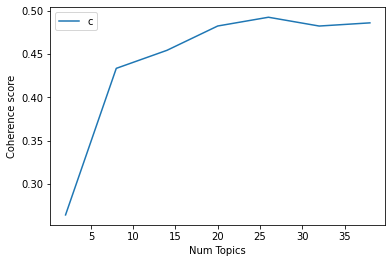

Num Topics = 2  has Coherence Value of 0.2639
Num Topics = 8  has Coherence Value of 0.4336
Num Topics = 14  has Coherence Value of 0.4545
Num Topics = 20  has Coherence Value of 0.4827
Num Topics = 26  has Coherence Value of 0.4928
Num Topics = 32  has Coherence Value of 0.4826
Num Topics = 38  has Coherence Value of 0.4863


In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [152]:
# From the graph above, select the model and print the topics
# Update the optimal_model by modifying the value of model_list
# Note: the value represents the optimal model selected from the graph
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.030*"pandemic" + 0.021*"stock" + 0.019*"great" + 0.018*"find" + '
  '0.018*"free" + 0.015*"hit" + 0.013*"buy" + 0.013*"post" + 0.013*"share" + '
  '0.011*"story"'),
 (1,
  '0.090*"test" + 0.070*"covid" + 0.054*"testing" + 0.029*"show" + '
  '0.027*"ronavirus" + 0.027*"positive" + 0.023*"patient" + 0.022*"hospital" + '
  '0.017*"symptom" + 0.014*"doctor"'),
 (2,
  '0.052*"trump" + 0.037*"world" + 0.025*"realdonaldtrump" + 0.022*"lie" + '
  '0.014*"wrong" + 0.014*"dead" + 0.012*"vote" + 0.012*"fact" + 0.011*"stop" + '
  '0.011*"medium"'),
 (3,
  '0.067*"home" + 0.048*"stay" + 0.048*"work" + 0.040*"back" + 0.039*"people" '
  '+ 0.036*"open" + 0.032*"live" + 0.025*"order" + 0.022*"close" + '
  '0.021*"place"'),
 (4,
  '0.079*"day" + 0.042*"week" + 0.041*"good" + 0.035*"today" + 0.024*"love" + '
  '0.023*"news" + 0.021*"wait" + 0.018*"friend" + 0.017*"hope" + '
  '0.015*"break"'),
 (5,
  '0.135*"sick" + 0.033*"feel" + 0.028*"make" + 0.023*"watch" + 0.023*"man" + '
  '0.021*"fuck" 

In [155]:
# Save selected model for later use
# save(fname_or_handle, separately=None, sep_limit=10485760, ignore=frozenset({}), pickle_protocol=2)
optimal_model.save('/Volumes/twitter_project/models/lda_014_topics_model', separately=None, sep_limit=10485760)

In [153]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1387,"test, covid, testing, show, ronavirus, positiv...",@WerderEdESPN He only said that the unty’s tes...
1,1,2.0,0.1013,"trump, world, realdonaldtrump, lie, wrong, dea...",Visual of how Trump's inaction caused a signif...
2,2,0.0,0.0863,"pandemic, stock, great, find, free, hit, buy, ...",Virus expenses hit Amazon's bottom line ://t....
3,3,7.0,0.1114,"pandemic, make, time, life, thing, good, big, ...","In normal times, social media brings chaos; in..."
4,4,1.0,0.1478,"test, covid, testing, show, ronavirus, positiv...",Oregon is expanding it's COVID-19 testing capa...
5,5,11.0,0.0848,"lockdown, due, send, start, month, extend, giv...",Spring sports seasons around the untry will no...
6,6,1.0,0.1225,"test, covid, testing, show, ronavirus, positiv...","Cops, who arrested woman with drugs get quaran..."
7,7,1.0,0.0999,"test, covid, testing, show, ronavirus, positiv...","#OurAMA's past, present and inming presidents ..."
8,8,8.0,0.1153,"amp, pandemic, ronavirus, call, response, outb...",Potential surge of EMS calls flattened for loc...
9,9,11.0,0.1133,"lockdown, due, send, start, month, extend, giv...",California Water Service announced that it is ...


In [156]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

print(sent_topics_sorteddf_mallet.head())

   Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.3050   
1        1.0              0.2595   
2        2.0              0.2610   
3        3.0              0.2811   
4        4.0              0.2551   

                                            Keywords  \
0  pandemic, stock, great, find, free, hit, buy, ...   
1  test, covid, testing, show, ronavirus, positiv...   
2  trump, world, realdonaldtrump, lie, wrong, dea...   
3  home, stay, work, back, people, open, live, or...   
4  day, week, good, today, love, news, wait, frie...   

                                                Text  
0  Less than 5,000 gals.PROVES I'm a GREAT Captai...  
1  @jccaylen My recent genetic tests show a very ...  
2  @MinnesotaExpat @thedude77 @Arazel50 @starr_pa...  
3  @CNN NYC SUBWAY...STAYED OPEN WALMART...STAYED...  
4  @bearski55 Weekend again.Time still goes as qu...  


In [157]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

print(df_dominant_topics)

          Dominant_Topic                                     Topic_Keywords  \
0.0                  1.0  test, covid, testing, show, ronavirus, positiv...   
1.0                  2.0  trump, world, realdonaldtrump, lie, wrong, dea...   
2.0                  0.0  pandemic, stock, great, find, free, hit, buy, ...   
3.0                  7.0  pandemic, make, time, life, thing, good, big, ...   
4.0                  1.0  test, covid, testing, show, ronavirus, positiv...   
...                  ...                                                ...   
299995.0             6.0  state, government, health, follow, plan, publi...   
299996.0             9.0  work, pay, give, unemployment, care, job, mone...   
299997.0             8.0  amp, pandemic, ronavirus, call, response, outb...   
299998.0            11.0  lockdown, due, send, start, month, extend, giv...   
299999.0            12.0  time, year, happen, end, read, uld, check, lot...   

          Num_Documents  Perc_Documents  
0.0      